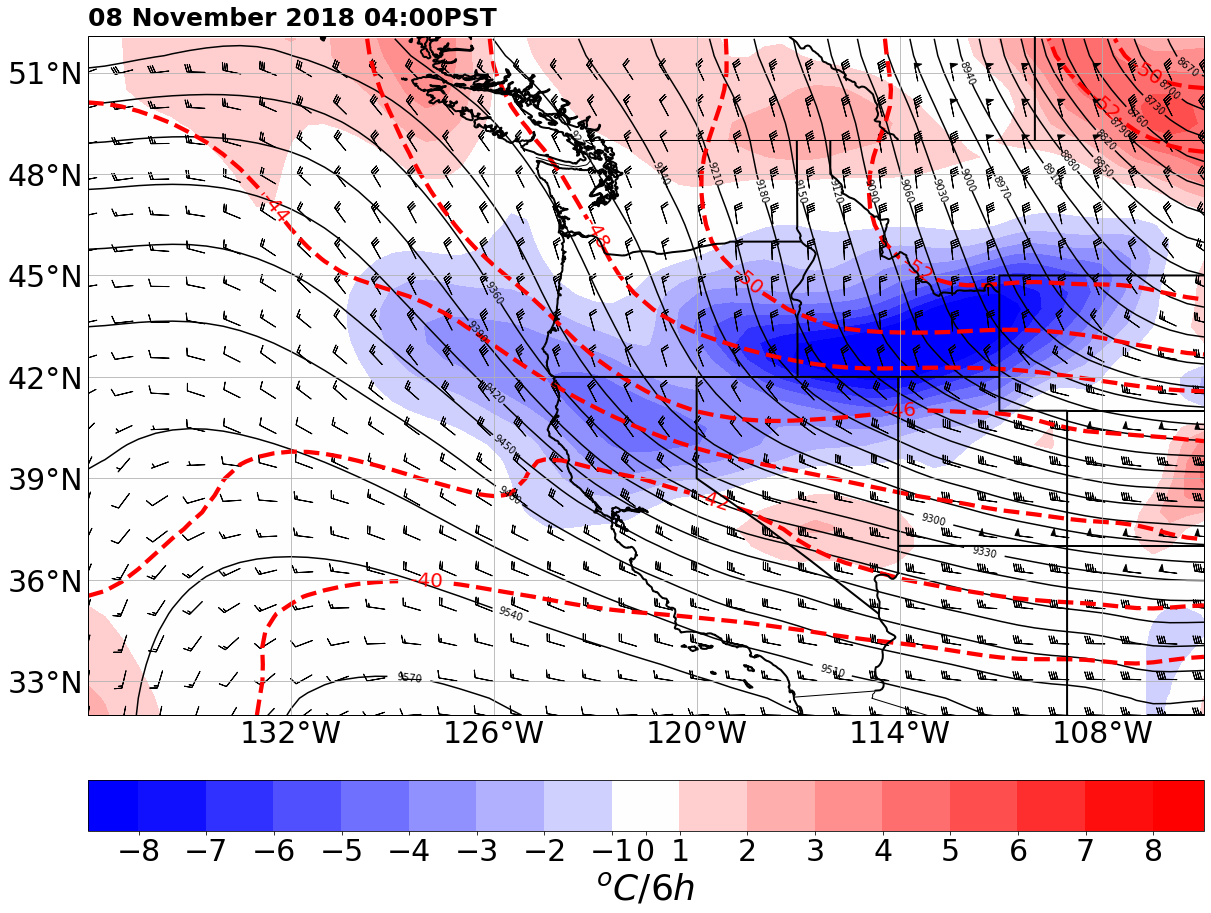

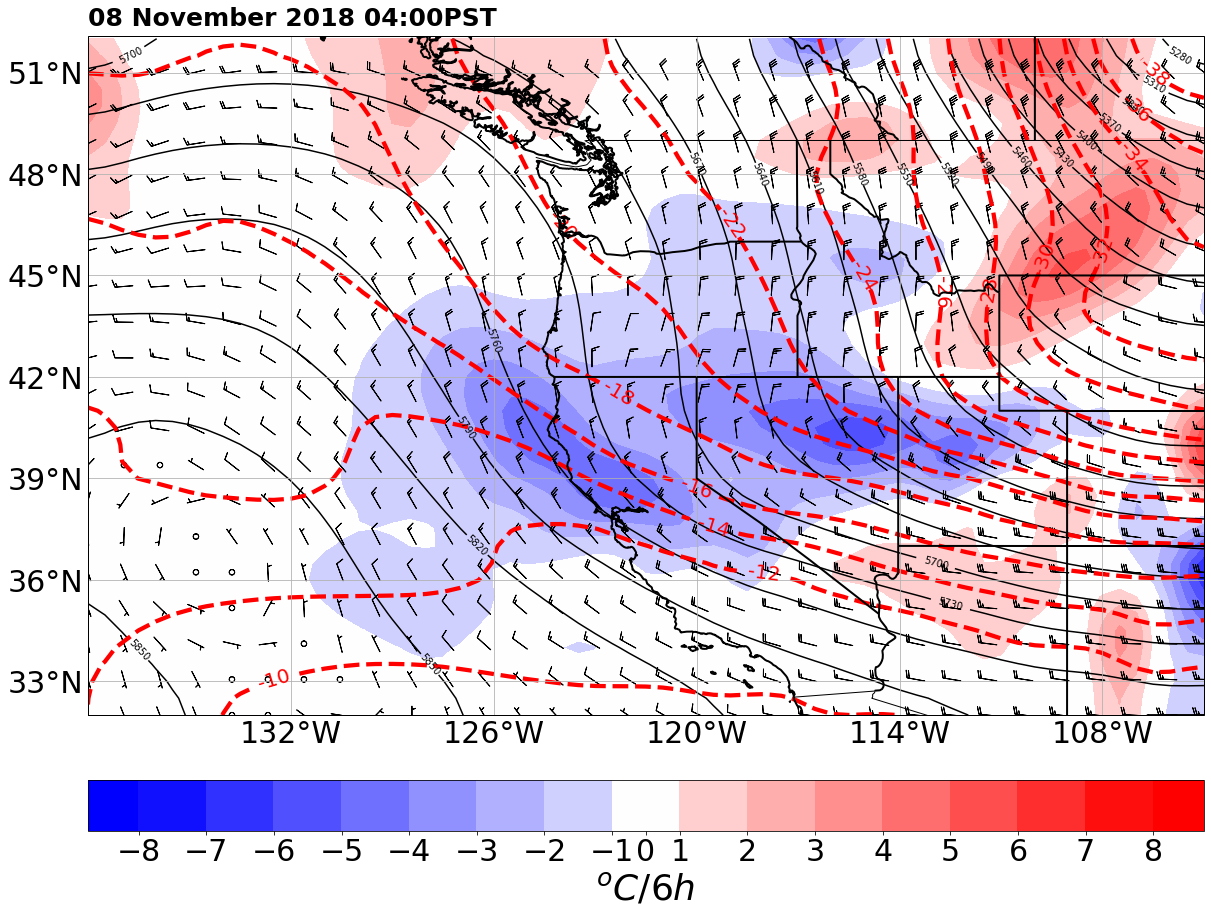

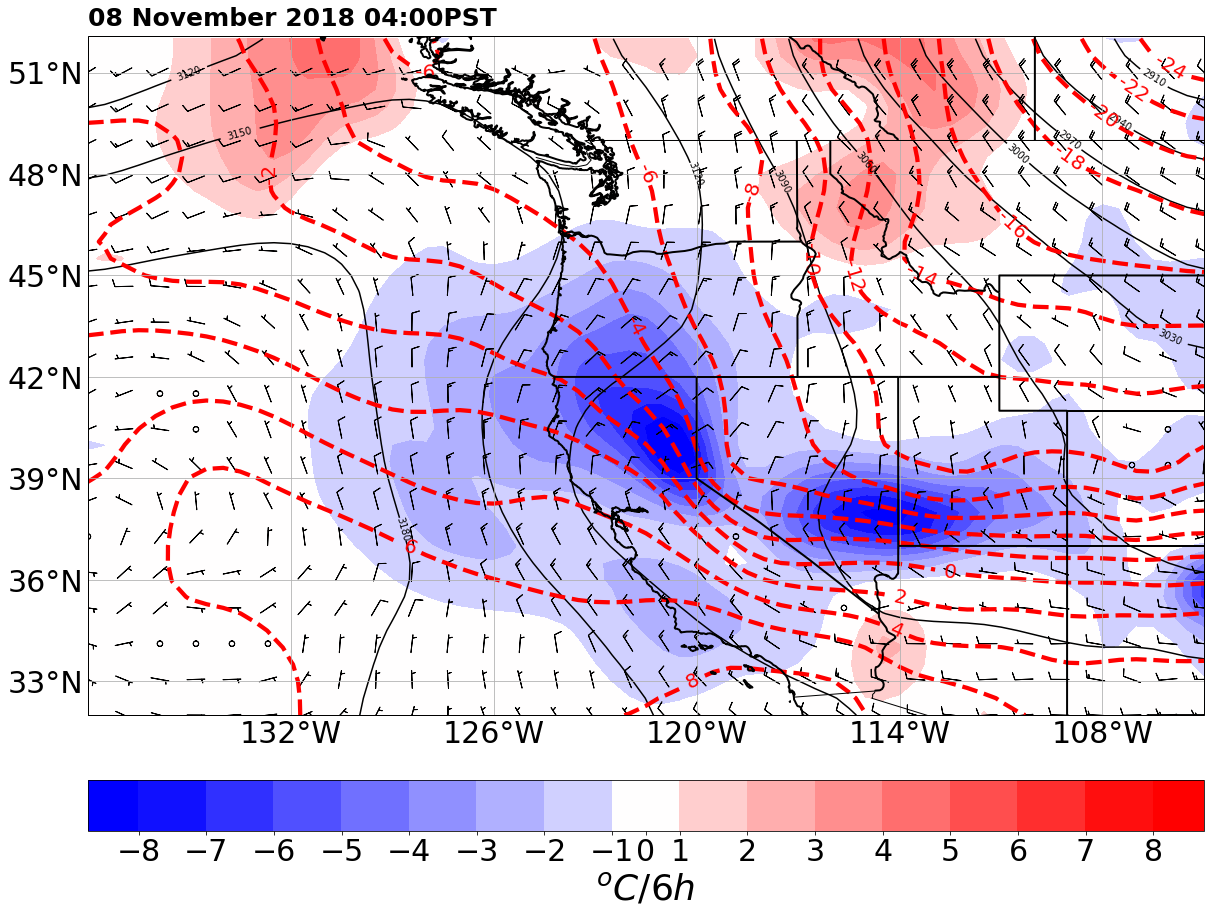

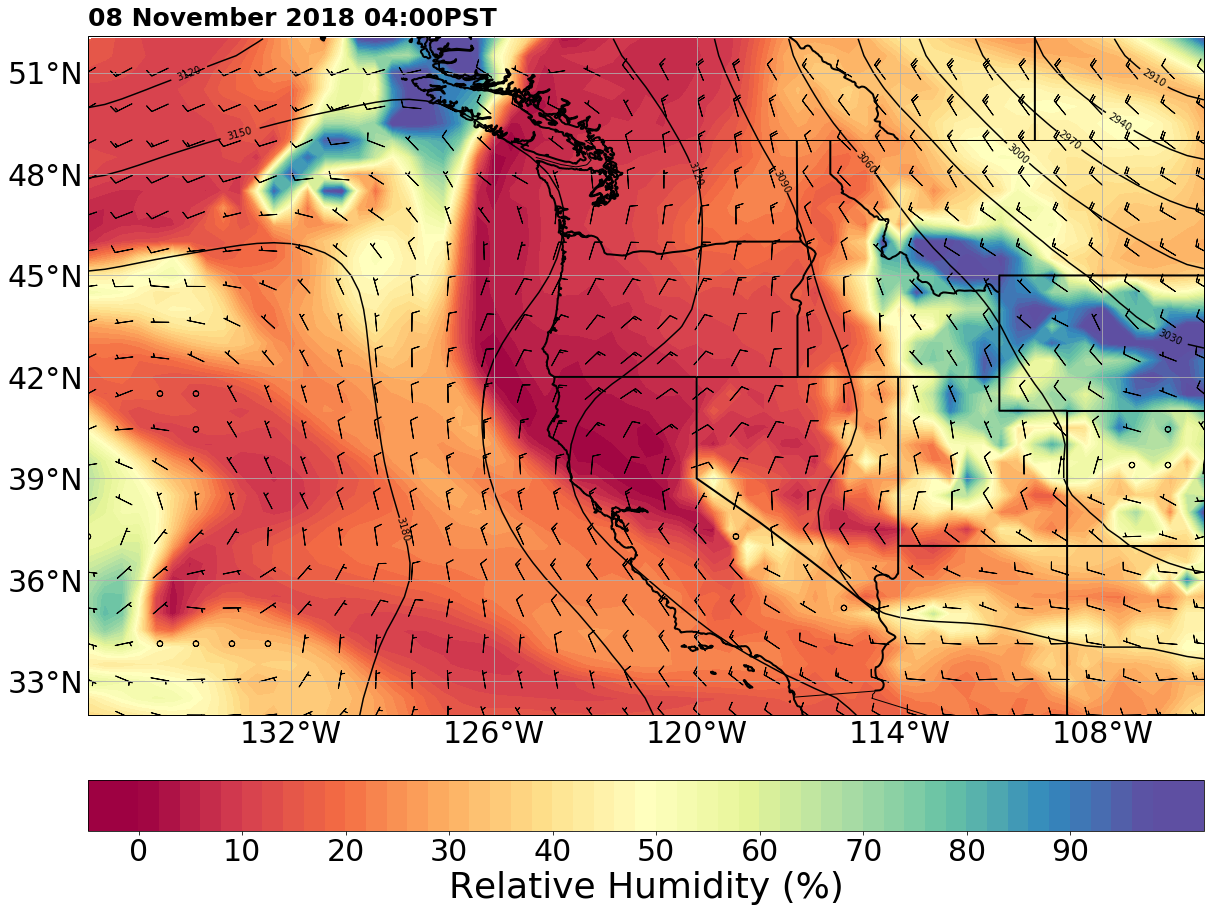

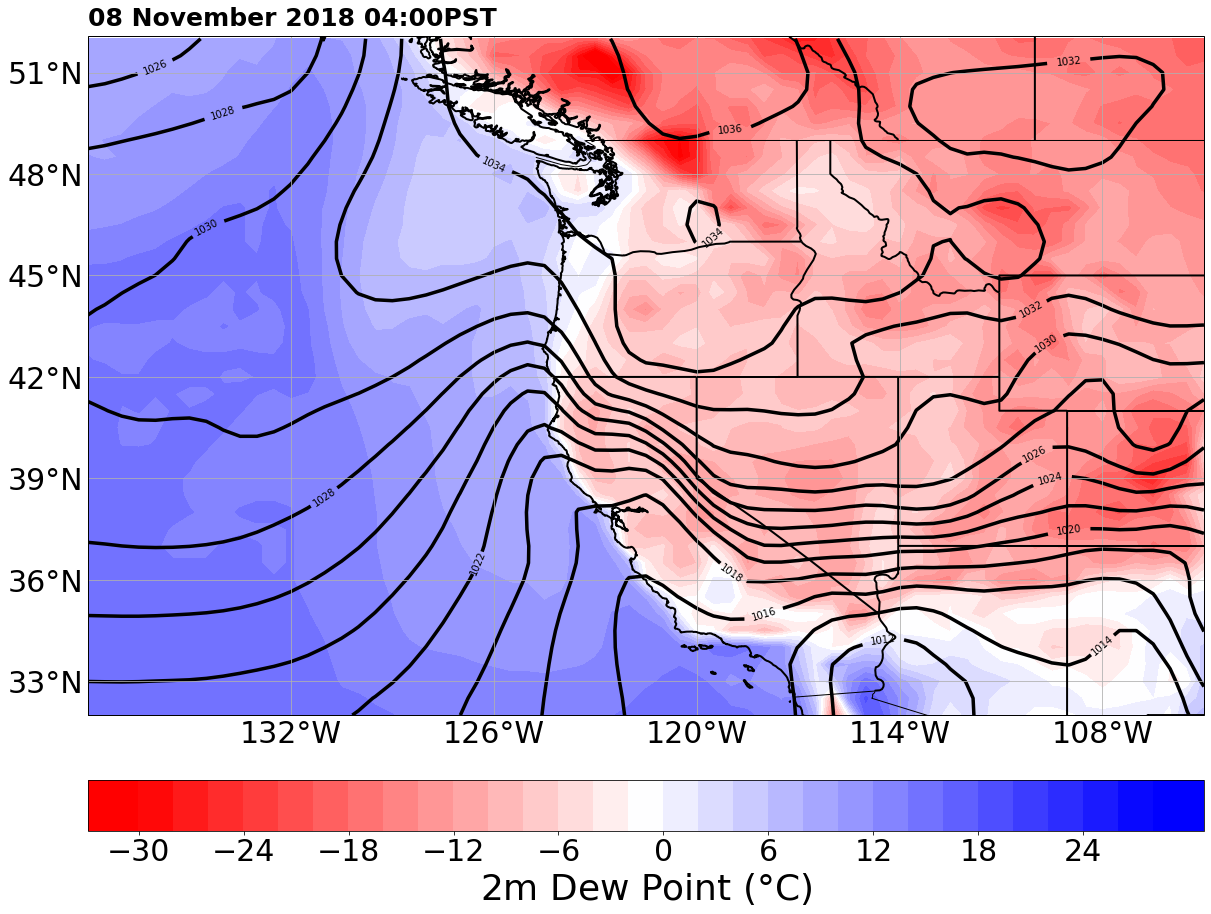

In [2]:
import matplotlib as mpl
import xarray as xr
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
from metpy.plots import USCOUNTIES # Make sure metpy is updated to latest version.
import datetime
import pandas as pd
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage
from siphon.ncss import NCSS

%matplotlib inline
plt.rcParams.update({"font.size":30})
mpl.rcParams['legend.fontsize'] = 'large'
#######################################
# Data Aquisition
# ---------------
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)
# Open the example netCDF data
base_url = 'https://www.ncei.noaa.gov/thredds/ncss/grid/gfs-g4-anl-files/'
dt = datetime(2018, 11, 8,12)
ncss = NCSS('{}{dt:%Y%m}/{dt:%Y%m%d}/gfsanl_4_{dt:%Y%m%d}_'
            '{dt:%H}00_000.grb2'.format(base_url, dt=dt))
# Create lat/lon box for location you want to get data for
query = ncss.query().time(dt)
query.lonlat_box(north=52, south=32, east=255, west=222)
query.accept('netcdf')

# Request data for vorticity
query.variables('Geopotential_height_isobaric', 'Temperature_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric','Dewpoint_temperature_height_above_ground', 'Relative_humidity_isobaric','MSLP_Eta_model_reduction_msl')
data = ncss.get_data(query)

# Pull out variables you want to use
hght_var = data.variables['Geopotential_height_isobaric']
temp_var = data.variables['Temperature_isobaric']
u_wind_var = data.variables['u-component_of_wind_isobaric']
v_wind_var = data.variables['v-component_of_wind_isobaric']
time_var = data.variables[find_time_var(temp_var)]
lat_var = data.variables['lat']
lon_var = data.variables['lon']
dpt_2m_var = data.variables['Dewpoint_temperature_height_above_ground']
rh_var = data.variables['Relative_humidity_isobaric']
mslp_var = data.variables['MSLP_Eta_model_reduction_msl']
# Get actual data values and remove any size 1 dimensions
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
hght = hght_var[:].squeeze()
temp = temp_var[:].squeeze() * units.K
u_wind = units('m/s') * u_wind_var[:].squeeze()
v_wind = units('m/s') * v_wind_var[:].squeeze()
mslp = units('Pa') * mslp_var[:].squeeze()
rh = rh_var[:].squeeze()
dpt_2m = units('K') * dpt_2m_var[:].squeeze()

# Convert number of hours since the reference time into an actual date
time = num2date(time_var[:].squeeze(), time_var.units)
tz = pd.to_datetime(time).tz_localize('UTC').tz_convert('US/Pacific')
# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)
# Gridshift for barbs
lon_2d[lon_2d > 180] = lon_2d[lon_2d > 180] - 360

# Use helper function defined above to calculate distance
# between lat/lon grid points
dx, dy = mpcalc.lat_lon_grid_deltas(lon_var, lat_var)

# Set Projection of Data
datacrs = ccrs.PlateCarree()


# Function used to create the map subplots
def plot_background(ax):
    ax.set_extent([-105+360.,-138+360., 32., 51.])
    ax.coastlines(resolution='10m', linewidth=2, color = 'black', zorder = 4)
    political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='10m', facecolor='none')
    states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')

    ax.add_feature(political_boundaries, linestyle='-', edgecolor='black', zorder =4)
    ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2, zorder =4)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    return ax

###############################################################################################
################################ creating plots ###############################################
###############################################################################################


###############################################################################################
#################################### 300mb temp adv ###########################################
###############################################################################################

lev_300 = np.where(data.variables['isobaric'][:] == 300*100)[0][0]
hght_300 = hght[lev_300]
temp_300 = temp[lev_300]
u_wind_300 = u_wind[lev_300]
v_wind_300 = v_wind[lev_300]


# Calculate temperature advection using metpy function
adv = mpcalc.advection(temp_300 * units.kelvin, [u_wind_300, v_wind_300],
                       (dx, dy)) * units('K/sec')

# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
Z_300 = ndimage.gaussian_filter(hght_300, sigma=1.5, order=0) * units.meter
adv_300 = ndimage.gaussian_filter(adv, sigma=1.5, order=0) * units('K/sec')


# Create new figure
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0, wspace=0.01)

# Add the map and set the extent
ax = plt.subplot(gs[0], projection=datacrs)
plt.title('{0:%d %B %Y %H:%MPST}'.format(tz), fontsize=25,loc = 'left', fontweight = 'bold', pad = 10.5)

plot_background(ax)

# Plot Height Contours
clev300 = np.arange(900, 12000, 30)
cs = ax.contour(lon_2d, lat_2d, Z_300, clev300, colors='black', linewidths=1.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevtemp300 = np.arange(-70, 20, 2)
cs2 = ax.contour(lon_2d, lat_2d, ndimage.gaussian_filter( temp_300.to(units('degC')),sigma = 1.5, order = 0), clevtemp300,
                 colors='red', linewidths=4.25, linestyles='dashed',
                 transform=datacrs)
plt.clabel(cs2, fontsize=20, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Temperature Advection
cint = np.arange(-8, 9)
cf = ax.contourf(lon_2d, lat_2d, 6*adv_300.to(units('delta_degC/hour')), cint[cint != 0],
                 extend='both', cmap='bwr', transform=datacrs)
#cax = plt.subplot(gs[1])
cb = fig.colorbar(cf, ax =ax, orientation='horizontal', extendrect=True, ticks=cint, pad = 0.05)
cb.set_label(r'$^{o}C/6h$', size='large')

# Plot Wind Barbs
ax.barbs(lon_2d, lat_2d, u_wind_300.magnitude, v_wind_300.magnitude,
         length=6, regrid_shape=20, pivot='middle', transform=datacrs)
plt.savefig('300mb_tempadv_{0:%Y%m%d%HPST}.png'.format(tz), dpi = 250)

###############################################################################################################
#################################### 500mb ####################################################################
###############################################################################################################


lev_500 = np.where(data.variables['isobaric'][:] == 500*100)[0][0]
hght_500 = hght[lev_500]
temp_500 = temp[lev_500]
u_wind_500 = u_wind[lev_500]
v_wind_500 = v_wind[lev_500]


# Calculate temperature advection using metpy function
adv = mpcalc.advection(temp_500 * units.kelvin, [u_wind_500, v_wind_500],
                       (dx, dy)) * units('K/sec')

# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
Z_500 = ndimage.gaussian_filter(hght_500, sigma=1.5, order=0) * units.meter
adv_500 = ndimage.gaussian_filter(adv, sigma=1.5, order=0) * units('K/sec')


# Create new figure
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0, wspace=0.01)

# Add the map and set the extent
ax = plt.subplot(gs[0], projection=datacrs)
plt.title('{0:%d %B %Y %H:%MPST}'.format(tz), fontsize=25,loc = 'left', fontweight = 'bold', pad = 10.5)

plot_background(ax)

# Plot Height Contours
clev500 = np.arange(900, 12000, 30)
cs = ax.contour(lon_2d, lat_2d, Z_500, clev500, colors='black', linewidths=1.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevtemp500 = np.arange(-70, 20, 2)
cs2 = ax.contour(lon_2d, lat_2d, ndimage.gaussian_filter( temp_500.to(units('degC')),sigma = 1.5, order = 0), clevtemp500,
                 colors='red', linewidths=4.25, linestyles='dashed',
                 transform=datacrs)
plt.clabel(cs2, fontsize=20, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Temperature Advection
cint = np.arange(-8, 9)
cf = ax.contourf(lon_2d, lat_2d, 6*adv_500.to(units('delta_degC/hour')), cint[cint != 0],
                 extend='both', cmap='bwr', transform=datacrs)
#cax = plt.subplot(gs[1])
cb = fig.colorbar(cf, ax =ax, orientation='horizontal', extendrect=True, ticks=cint, pad = 0.05)
cb.set_label(r'$^{o}C/6h$', size='large')

# Plot Wind Barbs
ax.barbs(lon_2d, lat_2d, u_wind_500.magnitude, v_wind_500.magnitude,
         length=6, regrid_shape=20, pivot='middle', transform=datacrs)
plt.savefig('500mb_tempadv_{0:%Y%m%d%HPST}.png'.format(tz), dpi = 250)

###############################################################################################################
#################################### 700mb ####################################################################
###############################################################################################################

lev_700 = np.where(data.variables['isobaric'][:] == 700*100)[0][0]
hght_700 = hght[lev_700]
temp_700 = temp[lev_700]
u_wind_700 = u_wind[lev_700]
v_wind_700 = v_wind[lev_700]


# Calculate temperature advection using metpy function
adv = mpcalc.advection(temp_700 * units.kelvin, [u_wind_700, v_wind_700],
                       (dx, dy)) * units('K/sec')

# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
Z_700 = ndimage.gaussian_filter(hght_700, sigma=1.5, order=0) * units.meter
adv_700 = ndimage.gaussian_filter(adv, sigma=1.5, order=0) * units('K/sec')


# Create new figure
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0, wspace=0.01)

# Add the map and set the extent
ax = plt.subplot(gs[0], projection=datacrs)
plt.title('{0:%d %B %Y %H:%MPST}'.format(tz), fontsize=25,loc = 'left', fontweight = 'bold', pad = 10.5)

plot_background(ax)

# Plot Height Contours
clev700 = np.arange(900, 12000, 30)
cs = ax.contour(lon_2d, lat_2d, Z_700, clev700, colors='black', linewidths=1.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevtemp700 = np.arange(-70, 20, 2)
cs2 = ax.contour(lon_2d, lat_2d, ndimage.gaussian_filter( temp_700.to(units('degC')),sigma = 1.5, order = 0), clevtemp700,
                 colors='red', linewidths=4.25, linestyles='dashed',
                 transform=datacrs)
plt.clabel(cs2, fontsize=20, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Temperature Advection
cint = np.arange(-8, 9)
cf = ax.contourf(lon_2d, lat_2d, 6*adv_700.to(units('delta_degC/hour')), cint[cint != 0],
                 extend='both', cmap='bwr', transform=datacrs)
#cax = plt.subplot(gs[1])
cb = fig.colorbar(cf, ax =ax, orientation='horizontal', extendrect=True, ticks=cint, pad = 0.05)
cb.set_label(r'$^{o}C/6h$', size='large')

# Plot Wind Barbs
ax.barbs(lon_2d, lat_2d, u_wind_700.magnitude, v_wind_700.magnitude,
         length=6, regrid_shape=20, pivot='middle', transform=datacrs)
plt.savefig('700mb_tempadv_{0:%Y%m%d%HPST}.png'.format(tz), dpi = 250)


###########################################################################################################
################################################ 700mb RH #################################################
###########################################################################################################

lev_700 = np.where(data.variables['isobaric'][:] == 700*100)[0][0]
hght_700 = hght[lev_700]
rh_700 = rh[lev_700]
u_wind_700 = u_wind[lev_700]
v_wind_700 = v_wind[lev_700]



# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
Z_700 = ndimage.gaussian_filter(hght_700, sigma=1.5, order=0) * units.meter


# Create new figure
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0, wspace=0.01)

# Add the map and set the extent
ax = plt.subplot(gs[0], projection=datacrs)
plt.title('{0:%d %B %Y %H:%MPST}'.format(tz), fontsize=25,loc = 'left', fontweight = 'bold', pad = 10.5)

plot_background(ax)

# Plot Height Contours
clev700 = np.arange(900, 12000, 30)
cs = ax.contour(lon_2d, lat_2d, Z_700, clev700, colors='black', linewidths=1.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevrh700 = np.arange(0, 100, 2)
cf = ax.contourf(lon_2d, lat_2d, rh_700, clevrh700,
                  extend='both', cmap='Spectral', transform=datacrs)

cb = fig.colorbar(cf, ax =ax, orientation='horizontal', extendrect=True, pad = 0.05)
cb.set_label('Relative Humidity (%)', size='large')

# Plot Wind Barbs
ax.barbs(lon_2d, lat_2d, u_wind_700.magnitude, v_wind_700.magnitude,
         length=6, regrid_shape=20, pivot='middle', transform=datacrs)
plt.savefig('700mb_RH_{0:%Y%m%d%HPST}.png'.format(tz), dpi = 250)


##########################################################################################
############################## mslp & 2m dpt #############################################
##########################################################################################

# Create new figure
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0, wspace=0.01)

# Add the map and set the extent
ax = plt.subplot(gs[0], projection=datacrs)
plt.title('{0:%d %B %Y %H:%MPST}'.format(tz), fontsize=25,loc = 'left', fontweight = 'bold', pad = 10.5)

plot_background(ax)

# Plot Height Contours
clevslp = np.arange(900, 1040, 2)
cs = ax.contour(lon_2d, lat_2d, ndimage.gaussian_filter( mslp/100,sigma=1, order=0), clevslp, colors='black', linewidths=3.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevdwpt = np.arange(-30, 30, 2)
cf = ax.contourf(lon_2d, lat_2d, dpt_2m.to(units('degC')), clevdwpt,
                  extend='both', cmap='bwr_r', transform=datacrs)

cb = fig.colorbar(cf, ax =ax, orientation='horizontal', extendrect=True, pad = 0.05)
cb.set_label(r'2m Dew Point ($\degree$C)', size='large')


plt.savefig('mslp_2m_dpt_{0:%Y%m%d%HPST}.png'.format(tz), dpi = 250)